## 알아봐야 할 것들



> 1. 그래프 분석 방법
> 2. import 새로운것들 (re, ... )
> 3. ignore warning 이거 왜하는거지
> 4. Stacking 이게 뭐야?





In [1]:
!pip install kaggle
!pip install kaggle --updatedd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --updatedd


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eomgisan","key":"2440ca3dd36638793976354533201c42"}'}

In [3]:
ls -1ha kaggle.json

kaggle.json


In [4]:
#json 파일 ~/.kaggle.로 이동


!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
#데이터셋 다운받기 : 해당대회 API 주소를 복사하고 그 앞에 !를 붙여서 코드 실행

!kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 25.7MB/s]


In [6]:
!ls


kaggle.json  sample_data  titanic.zip


In [7]:
#데이터 셋이 zip으로 다운되었으므로 압축 해제 해줘야함

!unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [8]:
!ls

gender_submission.csv  sample_data  titanic.zip
kaggle.json	       test.csv     train.csv


## Introuction

This notebook is very basic and simple introductory primer to the method of ensembling (combining) vase learning models, in particular the variant of ensembling known as Stacking. In a nutshell stacking uses as a first-level(base), the predictions of a few basic classifiers and then uses another model at the second-level to predict the output from the earlier first-levle predictions.

The Titanic dataset is a prime candidate for introducing this concept as many enwcomers to Kaggle start out here. Furthermore even though stacking has been responsible for many a team winng Kaggle competitions there seems to be a dearth of kernels on this topic so I hope this notebook can fill some what of that void.

I myself am quite a newcomer to the Kaggle scene as well an the first proper ensembling/stacking script that I managed to chance upon and study was one written in the AllState Severity Claims competition by the great Faron. The material in this notebook borrows heavily from Faron's script alyhough ported to factor in ensembles of classifiers whilst his was ensembles of regressors. Anyway please check out his script here:

[Stacking Starter][1] : by Faron 


Now onto the notebook at hand and I hope that it manages to do justice and convey the concept of ensembling in an intuitive and concise manner.  My other standalone Kaggle [script][2] which implements exactly the same ensembling steps (albeit with different parameters) discussed below gives a Public LB score of 0.808 which is good enough to get to the top 9% and runs just under 4 minutes. Therefore I am pretty sure there is a lot of room to improve and add on to that script. Anyways please feel free to leave me any comments with regards to how I can improve


  [1]: https://www.kaggle.com/mmueller/allstate-claims-severity/stacking-starter/run/390867
  [2]: https://www.kaggle.com/arthurtok/titanic/simple-stacking-with-xgboost-0-808

In [12]:
# Load in our libraries

import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

## Feature Exploration, Engineering and Cleaning

Now we will proceed much like how most kernels in general are structured, and that is to first explore the data on hand, identify possible feature engineering opportunities as well as numerically encode any categorical features.

In [30]:
#Load in the train and test datasets

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

# Store our passenger ID for easy access

PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Well it is no surprise that our task is to somehow extract teh information out of the categorical variables

####Feature Engineering

Here, credit must be extended to Sina's very comprehensive and well_thought out notebook for the feature enginnering ideas so please check out his work 

[Titanic Best Working Classfier][1] : by Sina


  [1]: https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier

In [31]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
train['Has_Cabin'] = train['Cabin'].apply(lambda x:0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x:0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch

for dataset in full_data:
  dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Create new feature IsAlone form FamilySize
for dataset in full_data:
  dataset['IsAlone'] = 0
  dataset.loc[dataset['FamilySize']==1, 'IsAlone'] = 1


# Remove all NULLS in the Embarked column
for dataset in full_data:
  dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
  dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# Create a New feature CategoricalAge
for dataset in full_data:
  age_avg = dataset['Age'].mean()
  age_std = dataset['Age'].std()
  age_null_count = dataset['Age'].isnull().sum()
  age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)
  dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
  dataset['Age'] = dataset['Age'].astype(int)

train['CategoricalAge'] = pd.cut(train['Age'], 5)

# Define funcion to extract titles from passenger names
def get_title(name):
  title_search = re.search('([A-Za-z]+)\.', name)
  # If the title exists, extract and return it.
  if title_search:
    return title_search.group(1)
  return ""

# Create a new feature Title, containing the tiltes of passenger names
for dataset in full_data:
  dataset['Title'] = dataset['Name'].apply(get_title)

# Group all non-common titles into one signle grouping "Rare"
for dataset in full_data:
  dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

  dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
  dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
  dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
  # Mapping Sex
  dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1}).astype(int)

  # Mapping Title
  title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
  dataset['Title'] = dataset['Title'].map(title_mapping)
  dataset['Title'] = dataset['Title'].fillna(0)

  # Mapping Embarked
  dataset['Embarked'] = dataset['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)

  # Mapping Fare
  dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
  dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
  dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
  dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
  dataset['Fare'] = dataset['Fare'].astype(int)
    
  # Mapping Age
  dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
  dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
  dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
  dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
  dataset.loc[ dataset['Age'] > 64, 'Age'] = 4


In [33]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements,axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test = test.drop(drop_elements, axis = 1)

All right so now having cleaned the features and extracted relevant information and dropped the categorical columns our features should now all be numeric, a format suitable to feed into our Machine Learning models. However before we proceed let us generate some simple correlation and distribution plots of our transformed dataset to observe ho

## Visualisations

In [34]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


#### Pearson Correlation Heatmap

let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utillise the Seaborn plotting package which allows us to plot heatmaps very conveninetly as follows. 

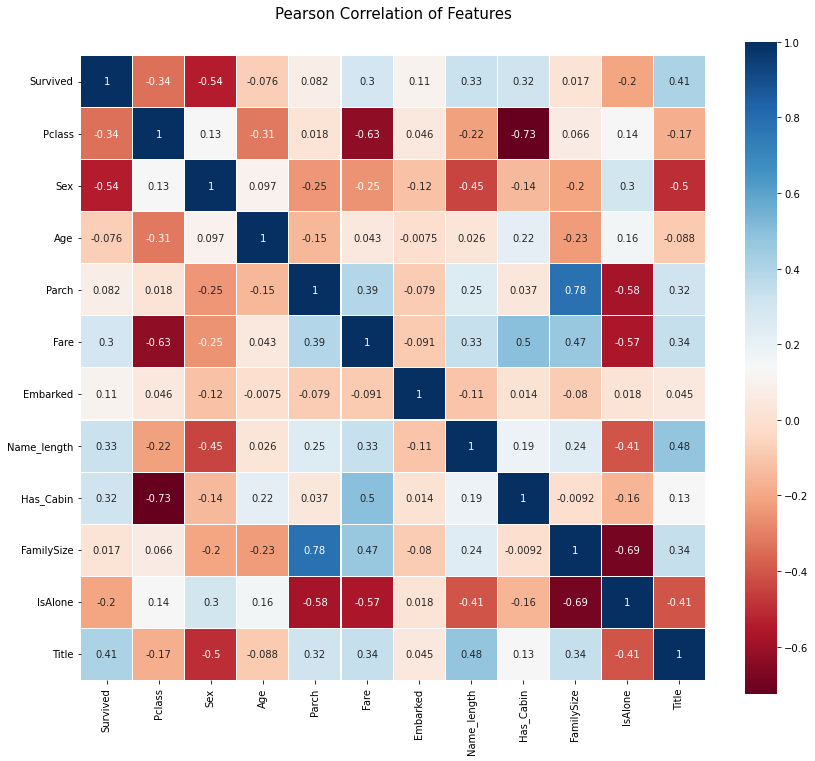

In [38]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size = 15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

#### Takeaway from the Plots
One thing that that the Pearson Correlation plot can tell us is that there are not too many features strongly correlated with one another. This is good from a point of view of feeding these features into your learning model because this means that there isn't much redundant or superfluous data in our training set and we are happy that each feature carries with it some unique information. Here are two most correlated features are that of Family size and Parch (Parents and Children). I'll still leave both features in for the purposes of this exercise.

#### Pairplots

Finally let us generate some pairplots to observe the distribution of data from one feature to the other. Once again we use Seaborn to help us.

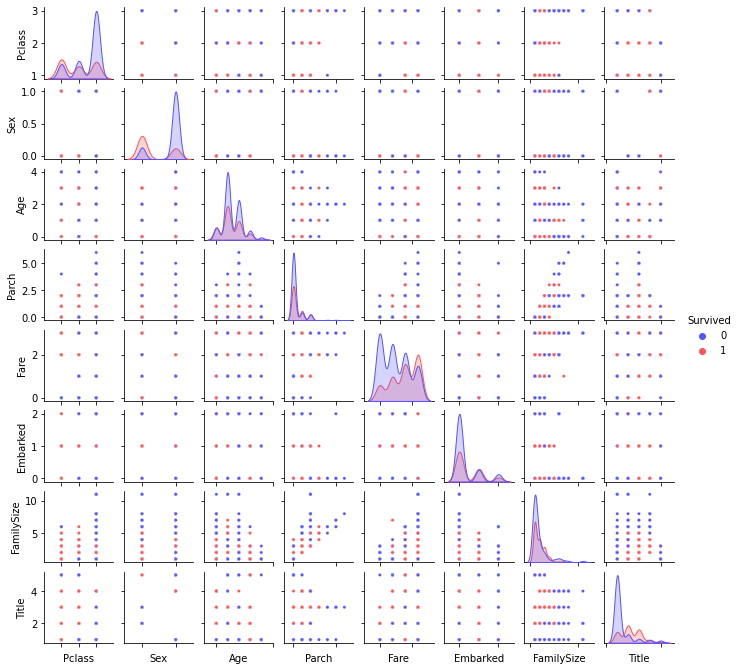

In [44]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked', 
     u'FamilySize', u'Title']], hue = 'Survived', palette = 'seismic', size = 1.2, diag_kind = 'kde', diag_kws = dict(shade=True), plot_kws = dict(s=10)  )
g.set(xticklabels = [])

## Ensembling & Stacking models

Finally after that brief whirwind detour with regards to feature engineering and formatting, we finally arrive at the meat and gist of the this notebook

Creating a Stacking ensemble!

**def init** : Python standard for invoking the default constructor for the class. This means that when you want to create an object (classifier), you have to give it the parameters of clf (what sklearn classifier you wnat), seed(randome seed) and params (parameters for the classifiers)

The rest of the code are simply methods of the class which simply call the corresponding methods already existing within the sklearn classifiers. Essentially, we have created a wrapper class to extend the various Sklearn classifiers so that this should help us reduce having to write the same code over and over when we implement multiple learners to our stacker.


#### Out-of-Fold Predictions

Now as alluded to above in the introductory section, stacking uses predictions of base classifiers as input for training to a second-level model. However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training. This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.